In [74]:
import numpy as np_ # Original numpy 
import scipy as sp

import random

# Plot
from IPython.display import display, Latex
import matplotlib.pyplot as plt

# PennyLane
import pennylane as qml
from pennylane import numpy as np

# qnode device
dev1 = qml.device('default.mixed', wires = 1)
dev2 = qml.device('default.mixed', wires = 2)
dev4 = qml.device('default.mixed', wires = 4)

# Building hamiltonian
coeffs = [-0.5]
coeffs_2 = [-0.5]
obs_1 = [qml.PauliZ(0)]
obs_2 = [qml.PauliZ(0) @ qml.PauliZ(1)]
obs_4 = [qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3)]

hamiltonian_1 = qml.Hamiltonian(coeffs, obs_1)  # Define Hamiltonian
hamiltonian_2 = qml.Hamiltonian(coeffs_2, obs_2)  # Define Hamiltonian
hamiltonian_4 = qml.Hamiltonian(coeffs, obs_4)  # Define Hamiltonian

$$
\sigma_z \otimes \sigma_z = 
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & -1 & 0 & 0 \\
0 & 0 & -1 & 0 \\
0 & 0 & 0 & 1 \\
\end{pmatrix}
$$

In [75]:
Pauli_Z = np.array([[1, 0],
                    [0, -1]])

obs_matrix = np.kron(Pauli_Z, Pauli_Z)
obs_custom = qml.Hermitian(obs_matrix, wires = [0, 1])

def Hamiltonian_custom(t):
    H_custom = qml.Hamiltonian((t, ), (obs_custom, ))
    
    return H_custom

In [76]:
def TimeEvo(t):
    qml.CZ(wires=[0, 1])
    
    qml.RZ(-t, wires=0)
    qml.RZ(-t, wires=1)

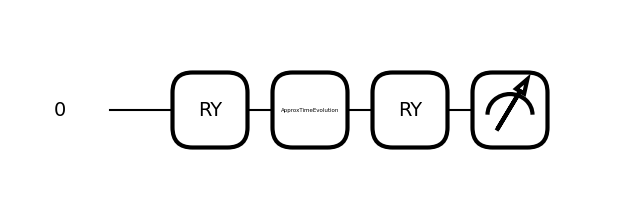

In [77]:
@qml.qnode(dev1)
def circuit_1(phi):    
    qml.RY(np.pi/2, wires=0)
    
    qml.ApproxTimeEvolution(hamiltonian_1, phi, 1)
    
    qml.RY(np.pi/2, wires=0)
    
    return qml.density_matrix(wires=0) 

fig, ax = qml.draw_mpl(circuit_1)(1)

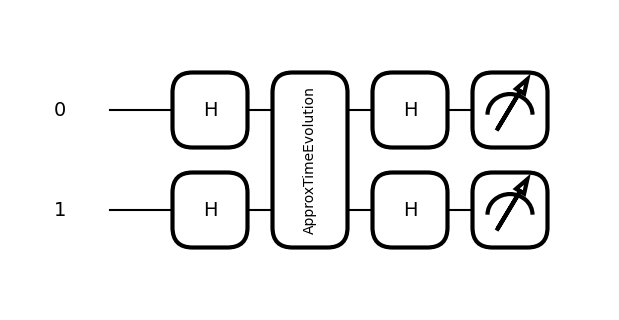

In [78]:
@qml.qnode(dev2)
def circuit_2(phi):    
    # qml.RY(np.pi/2, wires=0)
    # qml.RY(np.pi/2, wires=1)
    
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    
    qml.ApproxTimeEvolution(hamiltonian_2, phi, 1)  
    
    # qml.RY(np.pi/2, wires=0)
    # qml.RY(np.pi/2, wires=1)
    
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)

    return qml.density_matrix(wires=[0, 1]) 

fig, ax = qml.draw_mpl(circuit_2)(1)

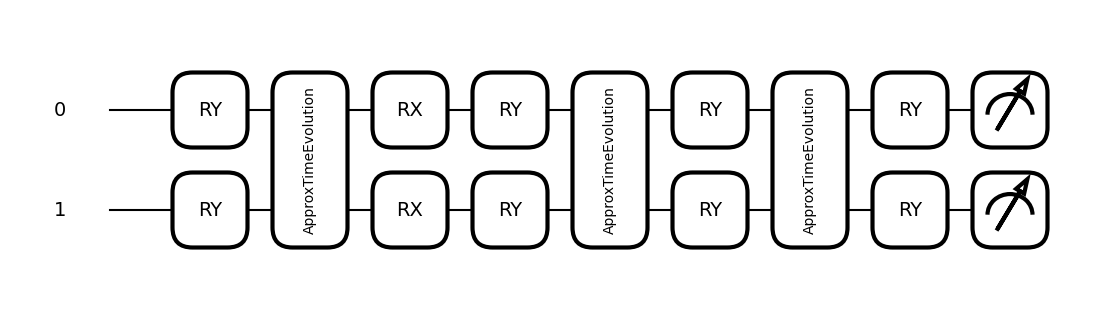

In [79]:
@qml.qnode(dev2)
def circuit_en(phi):    
    # Stage_1
    qml.RY(np.pi/2, wires=0)
    qml.RY(np.pi/2, wires=1)
    
    # Stage_2: Entnagler
    qml.ApproxTimeEvolution(hamiltonian_2, np.pi/8, 1)
    
    qml.RX(np.pi/2, wires=0)
    qml.RX(np.pi/2, wires=1)
    
    qml.RY(-np.pi/2, wires=0)
    qml.RY(-np.pi/2, wires=1)
    
    qml.ApproxTimeEvolution(hamiltonian_2, np.pi/4, 1)
    
    qml.RY(np.pi/2, wires=0)
    qml.RY(np.pi/2, wires=1)
    
    # Stage_3: Phase accumulator
    qml.ApproxTimeEvolution(hamiltonian_2, phi, 1)  # Hamiltonian => Same as entangler?
    
    qml.RY(np.pi/2, wires=0)
    qml.RY(np.pi/2, wires=1)
    
    return qml.density_matrix(wires=[0, 1])
    # return qml.probs(wires=[0, 1])
    

fig, ax = qml.draw_mpl(circuit_en)(1)

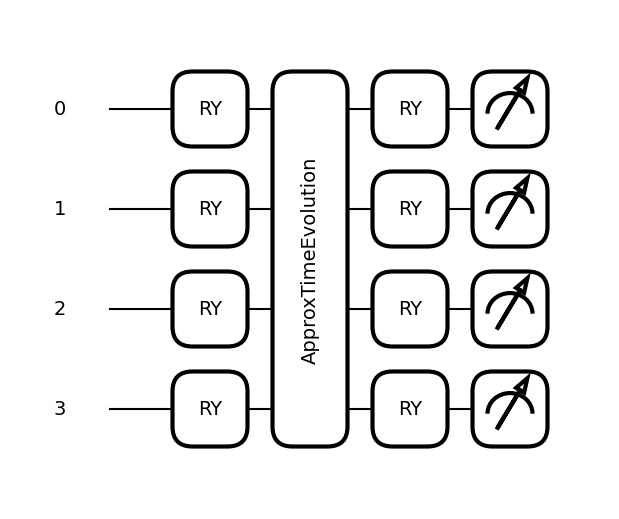

In [80]:
@qml.qnode(dev4)
def circuit_4(phi):    
    qml.RY(np.pi/2, wires=0)
    qml.RY(np.pi/2, wires=1)
    qml.RY(np.pi/2, wires=2)
    qml.RY(np.pi/2, wires=3)
    
    qml.ApproxTimeEvolution(hamiltonian_4, phi, 1)  
    
    qml.RY(np.pi/2, wires=0)
    qml.RY(np.pi/2, wires=1)
    qml.RY(np.pi/2, wires=2)
    qml.RY(np.pi/2, wires=3)

    return qml.density_matrix(wires=[0, 1, 2, 3]) 

fig, ax = qml.draw_mpl(circuit_4)(1)

In [81]:
# Sweep for 1e-4 ~ 3pi + 1e-4
PHI = np.arange(1e-4, 3*np.pi + 1e-4, 1e-1)
Data = np.zeros((4, len(PHI)))

DUMMY = np.zeros(len(PHI))

for i in range(len(PHI)):
    Data[0][i] = qml.qinfo.classical_fisher(circuit_1)(PHI[i])
    Data[1][i] = qml.qinfo.classical_fisher(circuit_2)(PHI[i])
    Data[2][i] = qml.qinfo.classical_fisher(circuit_en)(PHI[i])
    Data[3][i] = qml.qinfo.classical_fisher(circuit_4)(PHI[i])

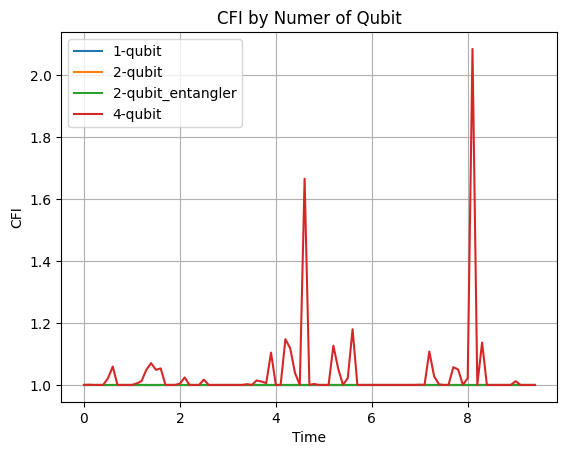

In [82]:
plt.title(f'CFI by Numer of Qubit')

plt.plot(PHI, Data[0][:], label = '1-qubit')
plt.plot(PHI, Data[1][:], label = '2-qubit')
plt.plot(PHI, Data[2][:], label = '2-qubit_entangler')
plt.plot(PHI, Data[3][:], label = '4-qubit')
# plt.plot(PHI, DUMMY, label = 'DUMMY')

plt.xlabel('Time')
plt.ylabel('CFI')
plt.grid()
plt.legend()